# Identification of Fake News: A Machine Learning Approach

Abstract:
Digital media has become the new go-to source for news consumption. It’s easy, convenient, and perfectly suits the on-the-go lifestyle that most people have now a days.

But the comfort comes at a price, as people, especially the young ones become very susceptible to half-truths or even absolutely false news propagated with an intention of spreading misinformation.

Hence, identifying false and unreliable news has recently become an emerging topic of research that is attracting tremendous attention.

The goal with this project is to develop a reliable model that classifies a given news article as either fake or true. 

## Introduction:
Fake news is defined as news spreading completely false information with an intention to manipulate or scam the readers.

A study conducted in 2018 regarding the spread of true and false news online concludes that “lies spread faster than the truth”, stating that fake news proliferates 6 times faster and reaches 10 times larger audience than the real ones.

Information bias as well as the rapid spread of fake news pose a great threat to the reader and are becoming a powerful weapon for gaining peoples’ attention and playing with their emotions. “Fake news” was even named the word of the year by the Macquarie dictionary in 2016.

In this project, we present an approach for identifying fake news efficiently that may help cease the spread of misinformation across all digital platforms.

## Probelm Definition:
As increasingly a major amount of our day to day lives is spent interacting online through social media platforms, more and more people tend to seek out and consume news from digital media rather than traditional news organizations. 

However, being the most convenient way of providing news online, it also aids in the dissemination of large volumes of fake news i.e., news articles with intentional false information, which are produced online for a variety of purposes, such as financial and political gain.

Hence, a readily available tool to identify false, agenda-driven news concocted by mixing misinformation with inadequate intention is the need of the hour. This is exactly what the proposed system aims to achieve.

## Solution Strategy:
(i) Collection of dataset: The dataset contains various news articles from around the world along with the title of the news article and its author.

(ii) Data preprocessing: In this step, various preprocessing methods were applied, and the data was made usable in the required context.

(iii) The preprocessed data was fed into the “Doc2Vec” model with some user given parameters, which performs word embedding. Here, the texts were converted into their respective vector representations.

(iv) Training of various models: The idea was to train a couple of classification models with the above data. The models include Naïve Bayes and SVM. Also, a neural network-based model was trained.

(v) Cross validation: After successfully training the models, those were to be tested on the unseen test data. In this proposed system, the whole dataset was split in the ratio 80:20 using the hold out method. The training data represents the 80% of the complete dataset and the testing was be done on the remaining 20%.

## Implementation Details:

## Step 1: Text Preprocessing

In [5]:
# importing required libraries
import numpy as np
import re
import string
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
import scikitplot.metrics as skplm
from sklearn.svm import SVC
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Input, RepeatVector
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# defining functions for text preprocessing
# first function for text preprocessing
def Data_Cleaning(text):
    # using regex to substitute anything except relevant characters like alphabets, numbers etc. with whitespace
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    
    # for convenience, converting all text to lower case
    text = text.lower().split()
    
    # storing all stopwords available in English in a variable called 'stops'
    stops = set(stopwords.words("english"))
    
    # removing all the stopwords from the text and appending the remaining ones in a variable called 'text'
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)

# second function for text preprocessing
def Final_Cleanup(text):
    text = Data_Cleaning(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

# third function for text preprocessing
def Construct_TaggedDocument(data):
    sentences = []
    
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

## Step 2: Feature Extraction

In [2]:
# defining a function to extract a feature vector of 300 dimensions out of every paragraph
def Embeddings(path,vector_dimension=300):
    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = Final_Cleanup(data.loc[i,'text'])
    

    x = Construct_TaggedDocument(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    text_train_arrays = np.zeros((train_size, vector_dimension))
    text_test_arrays = np.zeros((test_size, vector_dimension))
    train_labels = np.zeros(train_size)
    test_labels = np.zeros(test_size)

    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
        train_labels[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
        test_labels[j] = y[i]
        j = j + 1

    return text_train_arrays, text_test_arrays, train_labels, test_labels
    

## Model Training and evaluation
Model 1: Naive Bayes

In [3]:
def plot_cmatrix(yte, ypred):
    '''Plotting the confusion matrix'''
    skplm.plot_confusion_matrix(yte,ypred)
    plt.show()


xtr,xte,ytr,yte = Embeddings("train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

gnb = GaussianNB()
gnb.fit(xtr,ytr)
y_pred = gnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Congratulations,Your Model Has Been Trained!")
print("")
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 72.26%

plot_cmatrix(yte, y_pred)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

## Model Training and evaluation continued...
Model 2: Support Vector Machine

<ipython-input-9-751a31fa4525>:22: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)


Congratulations,Your Model Has Been Trained!

Accuracy = 91.62%


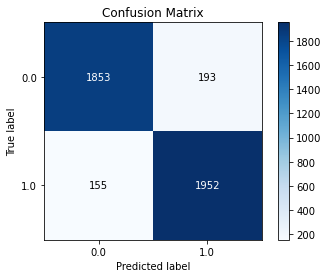

In [11]:
def plot_cmatrix(yte, ypred):
    '''Plotting the confusion matrix'''
    skplm.plot_confusion_matrix(yte,ypred)
    plt.show()


xtr,xte,ytr,yte = Embeddings("train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

clf = SVC()
clf.fit(xtr, ytr)
y_pred = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Congratulations,Your Model Has Been Trained!")
print("")
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 91.71%

plot_cmatrix(yte, y_pred)


## Model training and evaluation continued...
Model 3: A Neural Network with 3 hidden layers

<ipython-input-9-751a31fa4525>:22: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               77056     
                                                                 
 dense_41 (Dense)            (None, 256)               65792     
                                                                 
 dense_42 (Dense)            (None, 80)                20560     
                                                                 
 dense_43 (Dense)            (None, 2)                 162       
                                                                 
Total params: 163,570
Trainable params: 163,570
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
208/208 [==============================] - 1s 2ms/step - loss: 0.4684 - accuracy: 0.7877
Epoch 2/20
208/208 [==============================] - 0s 2ms/step - loss: 0.257

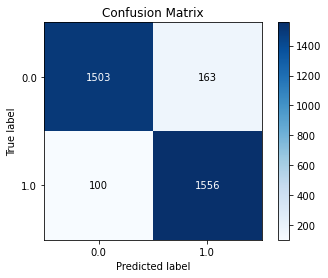

In [33]:
def plot_cmatrix(yte, ypred):
    '''Plotting the confusion matrix'''
    skplm.plot_confusion_matrix(yte,ypred)
    plt.show()


xtr,xte,ytr,yte = Embeddings("train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')


def baseline_model():
    '''Neural network(h3)'''
#     regularization: to make a model work well on both the training and testing data. Most common problem is overfitting.
#     tackling overfitting: The most interesting type of regularization is dropout.
#     dropout produces very good results and consequently, is the most frequently used regularization technique in deep learning
#     let's say that we have a neural network with 2 hidden layers. At every iteration, dropout randomly selects some nodes
#     and removes them along with their incoming and outgoing connections.
#     so, each iteration has a different set of nodes and this results in different sets of outputs.
#     these models usually perform better as they capture more randomness, and they memorize less of the training data
#     and hence are forced to generalize better and build a more robust predictive model.
    
    model = Sequential()
    model.add(Dense(256, input_dim=300, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.3)) #dropout layer 1
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5)) #dropout layer 2
    model.add(Dense(80, activation='relu', kernel_initializer='normal'))
    model.add(Dense(2, activation="softmax", kernel_initializer='normal'))

#   Using Stochastic Gradient Descent(SGD) as the optimizer
#   SGD is like GD, that uses a subset of training examples instead of the entire lot. 
#   SGD is an implementation of GD that uses batches on each pass
#   SGD uses momentum to accumulate gradients
#   momentum accumulates the gradients of the past steps to dictate what might happen in the next stpes.
#   SGD is less expensive computationally.
    
    
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    # configuring the learning process of the model
    #Formally, "categorical crossentropy" is designed to quantify the difference between two probability distributions.
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


model = baseline_model()
model.summary()
x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y = np_utils.to_categorical((label_encoder.transform(y_train)))
label_encoder.fit(y_test)
encoded_y_test = np_utils.to_categorical((label_encoder.transform(y_test)))
estimator = model.fit(x_train, encoded_y, epochs=20, batch_size=64)
print("Congratulations,Your Model Has Been Trained!")
score = model.evaluate(x_test, encoded_y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")   # 92.44%

probabs = model.predict(x_test)
y_pred = np.argmax(probabs, axis=1)
 
plot_cmatrix(y_test, y_pred)

## Conclusion:
Since the very beginning, the project had its own ebbs and flows. As students with limited previous exposure to the vast field of study that Machine learning is, it was a learning curve for us more than anything else.

Through building our knowledge of Python and Machine learning in a very gradual manner, we took on the project.

Out of the three models that were built, the Naive Bayes is a baseline model, which gave an accuracy of 72.26% in identifying fake news from an unseen test dataset, the second model viz. Support Vector Machine gave an exceptional accuracy of 91.71% on the same unseen test dataset, and the final model viz.the Neural network-based model gave an even better accuracy of 92.44%, which topped the list by successfully outperforming the previous two models.
Overall, it was a successful project carried out in the right spirit. 


## Limitations:
(i) The loss to value of information in a real scenario for news is very high. In the preprocessing steps, in addition to some of the unusable data, a lot of valuable information also gets removed. There is a certain need for better preprocessing approaches.

(ii) For a better model, we also will need to incorporate the specific authors who wrote the article, what kind of articles they have written in the past, what are their socio-political views etc., in our model for it to give better results in the future.

## Future Scope:
(i) For the accurate identification of fake news, we can add as features the source of the news, including any associated URLs, the topic of discussion (e.g., sports, music, science, politics etc.), country or geographic region of origin etc., which have not been explored in this project.

(ii) Moreover, we can also work upon other classifiers such as LSTM and try to achieve better accuracy.

(iii) An audacious work would be to actually deploy our model. Once it's on the web, even people with not-so-sound technical background can identify whether a given news article is fake or not.

## References:
[1] A. P. Sukhodolov and A. M. Bychkova, “Fake news as a modern media phenomenon: definition, types, role of fake news and ways of counteracting it,” Questions of theory and practice of journalism, vol. 6, no. 2, pp. 143–169, 2017.

[2] V. Soroush, R. Deb, and A. Sinan, “The spread of true and false news online,” Science, vol. 359, n. 6380, pp. 1146–1151, 2018.

[3]The Guardian, “‘Fake News’ named Word of the Year by Macquarie Dictionary.” theguardian.com.
https://www.theguardian.com/australia-news/2017/jan/25/fake-news-named-word-of-the-year-by-macquarie-dictionary?CMP=soc_568 (accessed March 10, 2022).

[4] Kai Shu; Huan Liu, “Detecting Fake News on Social Media” , Morgan & Claypool, 2019.doi: 10.2200/S00926ED1V01Y201906DMK018

[5] Analytics Vidhya, “Text Preprocessing in NLP with Python codes.”analyticsvidhya.com
https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/
(accessed March 20, 2022)

[6] D. Janakieva, G. Mirceva and S. Gievska, "Fake News Detection by Using Doc2Vec Representation Model and Various Classification Algorithms," 2021 44th International Convention on Information, Communication and Electronic Technology (MIPRO), 2021, pp. 223-228, doi: 10.23919/MIPRO52101.2021.9596928.

[7] Towards Data Science, “SVM Classifier and RBF Kernel - How to Make Better Models in Python.”towardsdatascience.com.
https://towardsdatascience.com/svm-classifier-and-rbf-kernel-how-to-make-better-models-in-python-73bb4914af5b (accessed May 10,2022)

[8] Kaggle, “Fake News data.”kaggle.com.
https://www.kaggle.com/competitions/fake-news/data (accessed March 15,2022)

[9] Cogito Tech, “Machine learning model validation services.”cogitotech.com.
https://www.cogitotech.com/ml-model-validation-services (accessed May 7,2022)

[10] CodeSpeedy, “Naïve Bayes Algorithm in Python.”codespeedy.com.
https://www.codespeedy.com/naive-bayes-algorithm-in-python/ (accessed May 5,2022)

[11] GitHub, “Understanding Word2Vec and Doc2Vec.”shuzhanfan.github.io.
https://shuzhanfan.github.io/2018/08/understanding-word2vec-and-doc2vec/ (accessed March 25,2022)
![image-4.png]